In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.generativeai import GenerativeModel
import google.generativeai as genai
import os
import openai
from dotenv import load_dotenv
import plotly.graph_objects as go
import plotly.express as px

load_dotenv()
gemini_api_key = os.getenv('GEMINI_API_KEY')

In [4]:
df = pd.read_csv('cleaned_hospital_data.csv')
print("Initial data shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows of data:")
print(df.head())
print("\nChecking for missing values:")
print(df.isnull().sum())
print("\nChecking unique values in categorical columns:")
for col in ['Doctor Type', 'Financial Class', 'Patient Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())

Initial data shape: (29998, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    29998 non-null  object
 1   Medication Revenue      29998 non-null  object
 2   Lab Cost                29998 non-null  object
 3   Consultation Revenue    29998 non-null  object
 4   Doctor Type             29998 non-null  object
 5   Financial Class         29998 non-null  object
 6   Patient Type            29998 non-null  object
 7   Entry Time              29998 non-null  object
 8   Post-Consultation Time  29998 non-null  object
 9   Completion Time         29998 non-null  object
 10  Patient ID              29998 non-null  object
dtypes: object(11)
memory usage: 2.5+ MB
None

First few rows of data:
         Date Medication Revenue Lab Cost Consultation Revenue Doctor Type  \
0  2019-11-04      

In [5]:

print("\nChecking sample values in monetary columns:")
for col in ['Medication Revenue', 'Lab Cost', 'Consultation Revenue']:
    print(f"\nSample values in {col}:")
    print(df[col].head())
print("\nChecking sample values in time columns:")
for col in ['Entry Time', 'Post-Consultation Time', 'Completion Time']:
    print(f"\nSample values in {col}:")
    print(df[col].head())

print("\nChecking for duplicates:")
print("Number of duplicate rows:", df.duplicated().sum())
print("Number of duplicate Patient IDs:", df['Patient ID'].duplicated().sum())


Checking sample values in monetary columns:

Sample values in Medication Revenue:
0    1183.22
1     738.48
2        660
3        600
4      591.6
Name: Medication Revenue, dtype: object

Sample values in Lab Cost:
0        10
1     $-   
2     $-   
3     $-   
4     $-   
Name: Lab Cost, dtype: object

Sample values in Consultation Revenue:
0     20.17
1        15
2     21.17
3     $-   
4        12
Name: Consultation Revenue, dtype: object

Checking sample values in time columns:

Sample values in Entry Time:
0    08:35:45
1    19:19:16
2    10:46:52
3    09:38:34
4    11:16:21
Name: Entry Time, dtype: object

Sample values in Post-Consultation Time:
0    09:17:54
1    21:02:36
2    11:56:25
3    10:55:50
4    12:06:49
Name: Post-Consultation Time, dtype: object

Sample values in Completion Time:
0    09:29:46
1    21:24:07
2    12:06:28
3    10:58:02
4    12:06:54
Name: Completion Time, dtype: object

Checking for duplicates:
Number of duplicate rows: 0
Number of duplicate Patient

In [ ]:
print("Unique values in monetary columns:")
print("\nMedication Revenue unique values:")
print(df['Medication Revenue'].unique()[:10])
print("\nLab Cost unique values:")
print(df['Lab Cost'].unique()[:10])
print("\nConsultation Revenue unique values:")
print(df['Consultation Revenue'].unique()[:10])

def clean_monetary_value(x):
    if isinstance(x, str):
        x = x.strip()

        if x in ['$-', '-', ' -', '$- ', ' - ', '']:
            return 0.0

        return float(x.replace('$', '').replace(',', '').strip())
    return float(x)
test_values = ['$100', '$-', '-', ' - ', '100', '1,000.50', '$1,000.50']
print("\nTesting cleaning function:")
for value in test_values:
    print(f"Original: '{value}' -> Cleaned: {clean_monetary_value(value)}")
try:
    df['Medication Revenue'] = df['Medication Revenue'].apply(clean_monetary_value)
    df['Lab Cost'] = df['Lab Cost'].apply(clean_monetary_value)
    df['Consultation Revenue'] = df['Consultation Revenue'].apply(clean_monetary_value)
    print("\nVerification after cleaning:")
    print("\nMedication Revenue sample:")
    print(df['Medication Revenue'].head())
    print("\nLab Cost sample:")
    print(df['Lab Cost'].head())
    print("\nConsultation Revenue sample:")
    print(df['Consultation Revenue'].head())
except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("Please share the output of the unique values check so we can handle any unexpected formats")

Unique values in monetary columns:

Medication Revenue unique values:
['1183.22' '738.48' '660' '600' '591.6' '586.8' '570.18' '493.85' '470.39'
 '468.02']

Lab Cost unique values:
['10' ' $-   ' '92.5' '120' '40' '129.8' '11' '28.04' '74' '25']

Consultation Revenue unique values:
['20.17' '15' '21.17' ' $-   ' '12' '13' '30' '35.52' '23.91' '8']

Testing cleaning function:
Original: '$100' -> Cleaned: 100.0
Original: '$-' -> Cleaned: 0.0
Original: '-' -> Cleaned: 0.0
Original: ' - ' -> Cleaned: 0.0
Original: '100' -> Cleaned: 100.0
Original: '1,000.50' -> Cleaned: 1000.5
Original: '$1,000.50' -> Cleaned: 1000.5

Verification after cleaning:

Medication Revenue sample:
0    1183.22
1     738.48
2     660.00
3     600.00
4     591.60
Name: Medication Revenue, dtype: float64

Lab Cost sample:
0    10.0
1     0.0
2     0.0
3     0.0
4     0.0
Name: Lab Cost, dtype: float64

Consultation Revenue sample:
0    20.17
1    15.00
2    21.17
3     0.00
4    12.00
Name: Consultation Revenue, dty

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
time_columns = ['Entry Time', 'Post-Consultation Time', 'Completion Time']
for col in time_columns:
    df[col] = pd.to_datetime(df[col])

categorical_columns = ['Doctor Type', 'Financial Class', 'Patient Type']
for col in categorical_columns:
    df[col] = df[col].str.strip().str.title()
    
print("Dataset Info after cleaning:")
print(df.info())

print("\nMonetary columns statistics:")
print(df[['Medication Revenue', 'Lab Cost', 'Consultation Revenue']].describe())

print("\nSample of datetime columns:")
print(df[['Date'] + time_columns].head())

print("\nUnique values in categorical columns:")
for col in categorical_columns:
    print(f"\n{col} unique values:")
    print(df[col].value_counts())

print("\nValidation Checks:")

print("\nMissing values:")
print(df.isnull().sum())

time_sequence_check = (df['Entry Time'] <= df['Post-Consultation Time']) & \
                     (df['Post-Consultation Time'] <= df['Completion Time'])
invalid_times = (~time_sequence_check).sum()
print(f"\nRows with invalid time sequences: {invalid_times}")

C:\Users\ESCANOR\AppData\Local\Temp\ipykernel_24996\4129068130.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\ESCANOR\AppData\Local\Temp\ipykernel_24996\4129068130.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
C:\Users\ESCANOR\AppData\Local\Temp\ipykernel_24996\4129068130.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


Dataset Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    29998 non-null  datetime64[ns]
 1   Medication Revenue      29998 non-null  float64       
 2   Lab Cost                29998 non-null  float64       
 3   Consultation Revenue    29998 non-null  float64       
 4   Doctor Type             29998 non-null  object        
 5   Financial Class         29998 non-null  object        
 6   Patient Type            29998 non-null  object        
 7   Entry Time              29998 non-null  datetime64[ns]
 8   Post-Consultation Time  29998 non-null  datetime64[ns]
 9   Completion Time         29998 non-null  datetime64[ns]
 10  Patient ID              29998 non-null  object        
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 2.5+ MB
None

Monet

In [8]:
df.to_csv('cleaned_hospital_data_final.csv', index=False)

In [ ]:
def analyze_time_issues():
    
    time_sequence_mask = ~((df['Entry Time'] <= df['Post-Consultation Time']) & 
                          (df['Post-Consultation Time'] <= df['Completion Time']))
    
    invalid_times_df = df[time_sequence_mask]
    
    print("Sample of invalid time sequences:")
    print(invalid_times_df[['Entry Time', 'Post-Consultation Time', 'Completion Time']].head())
    df['wait_time'] = (df['Post-Consultation Time'] - df['Entry Time']).dt.total_seconds() / 60
    df['consultation_time'] = (df['Completion Time'] - df['Post-Consultation Time']).dt.total_seconds() / 60
    df['total_time'] = (df['Completion Time'] - df['Entry Time']).dt.total_seconds() / 60
    
    return df

In [ ]:
def prepare_for_ai():
    
    df['day_of_week'] = df['Date'].dt.day_name()
    df['hour_of_day'] = df['Entry Time'].dt.hour
    df['month'] = df['Date'].dt.month
    

    df['total_revenue'] = df['Medication Revenue'] + df['Consultation Revenue']
    df['revenue_per_minute'] = df['total_revenue'] / df['total_time']
    

    df['cost_to_revenue_ratio'] = df['Lab Cost'] / df['total_revenue']
    
    return df

def generate_insights():
    insights = {
        'revenue_by_day': df.groupby('day_of_week')['total_revenue'].mean().sort_values(ascending=False),
        'busiest_hours': df.groupby('hour_of_day').size().sort_values(ascending=False),
        'avg_wait_time_by_doctor': df.groupby('Doctor Type')['wait_time'].mean().sort_values(ascending=False),
        'revenue_by_patient_type': df.groupby('Patient Type')['total_revenue'].mean(),
        'efficiency_by_doctor': df.groupby('Doctor Type')['revenue_per_minute'].mean().sort_values(ascending=False)
    }
    
    return insights

def analyze_with_gemini(insights_dict):
    try:
        genai.configure(api_key=gemini_api_key)
        model = GenerativeModel('gemini-pro')
        
        # Prepare insights for Gemini
        insight_prompt = f"""
        Analyze these hospital operations metrics:
        1. Revenue by day: {insights['revenue_by_day'].to_dict()}
        2. Patient wait times: {insights['avg_wait_time_by_doctor'].to_dict()}
        3. Revenue efficiency: {insights['revenue_by_patient_type'].to_dict()}
        
        Provide:
        1. Key patterns and anomalies
        2. Optimization recommendations
        3. Revenue improvement opportunities
        """
        
        response = model.generate_content(insight_prompt)
        return response.text
        
    except Exception as e:
        return f"Error in Gemini analysis: {str(e)}"

# Execute the analysis
try:
    
    df = analyze_time_issues()
    
    
    df = prepare_for_ai()
    

    insights = generate_insights()
    
    
    gemini_analysis = analyze_with_gemini(insights)

    print("\nKey Insights:")
    
    print("\nGemini Analysis:")
    print(gemini_analysis)
    
    df.to_csv('hospital_data_ai_ready.csv', index=False)
    
except Exception as e:
    print(f"Error in analysis: {str(e)}")


Sample of invalid time sequences:
             Entry Time Post-Consultation Time     Completion Time
22  2024-10-29 14:12:06    2024-10-29 17:30:59 2024-10-29 15:32:48
142 2024-10-29 10:48:19    2024-10-29 12:09:14 2024-10-29 11:08:31
160 2024-10-29 09:58:14    2024-10-29 12:07:59 2024-10-29 11:21:53
173 2024-10-29 10:48:23    2024-10-29 14:10:54 2024-10-29 11:08:00
239 2024-10-29 09:26:49    2024-10-29 16:33:44 2024-10-29 10:24:45

Key Insights:

Gemini Analysis:
**1. Key Patterns and Anomalies**

* **Revenue by day:**
    * Weekends (Saturday and Sunday) have higher revenue than weekdays.
    * Revenue is relatively consistent throughout the week, with a slight dip on Tuesdays and Wednesdays.
* **Patient wait times:**
    * "Anchor" has significantly higher wait times than "Locum" and "Floating."
* **Revenue efficiency:**
    * Only "Outpatient" data is available, making it difficult to compare revenue efficiency across different departments.

**2. Optimization Recommendations**

* *

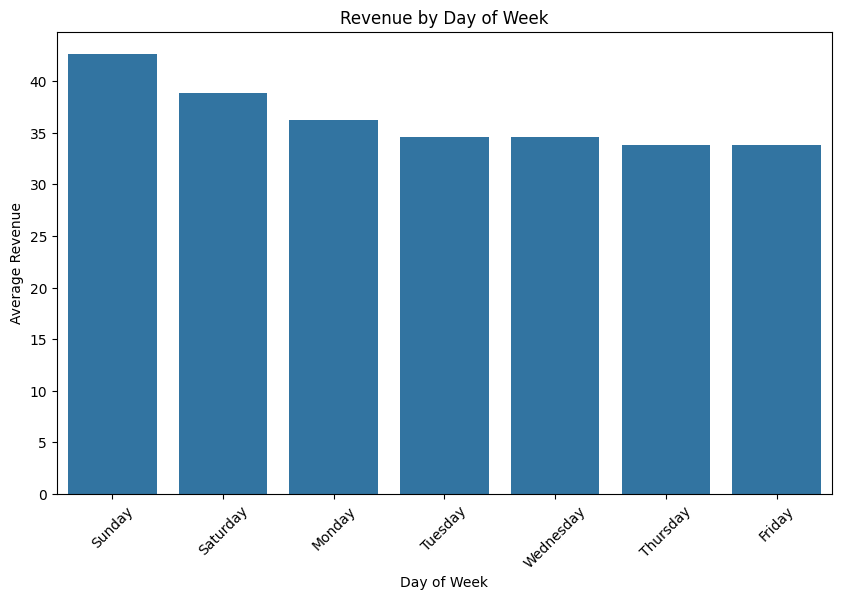

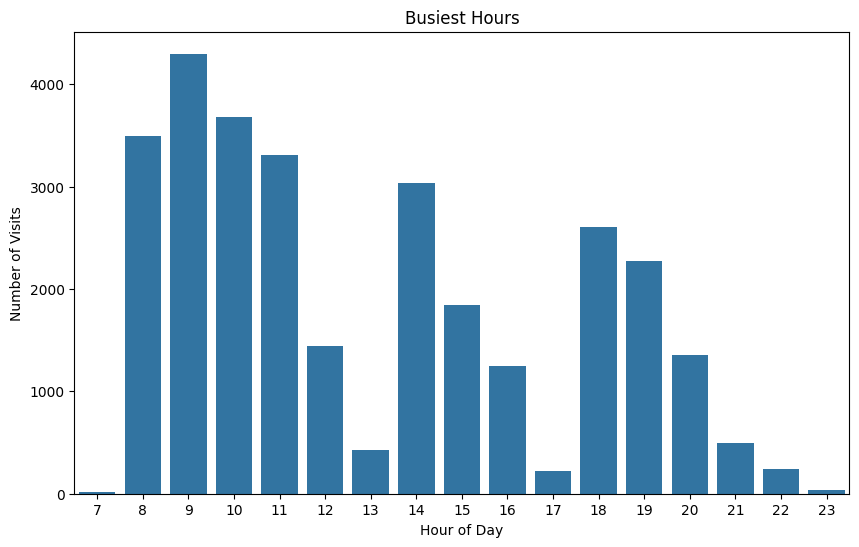

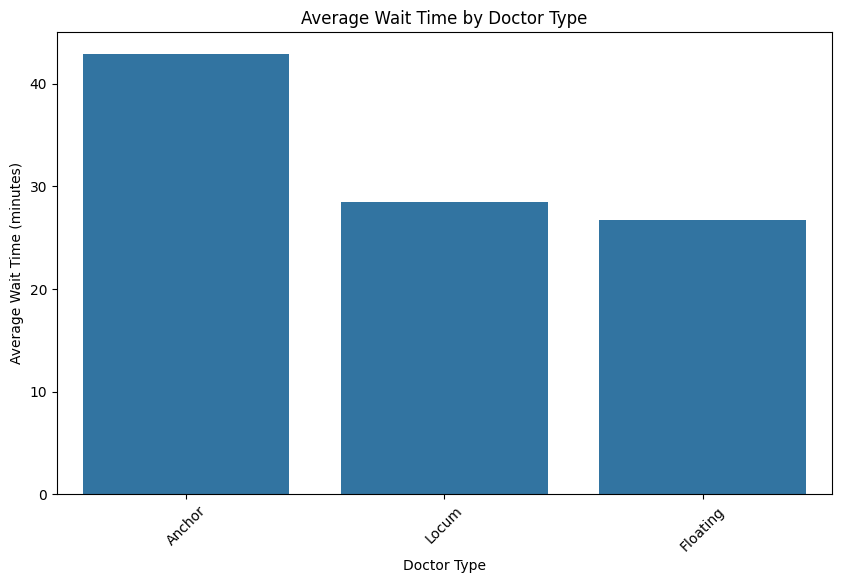

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=insights['revenue_by_day'].index, y=insights['revenue_by_day'].values)
plt.title('Revenue by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=insights['busiest_hours'].index, y=insights['busiest_hours'].values)
plt.title('Busiest Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Visits')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=insights['avg_wait_time_by_doctor'].index, y=insights['avg_wait_time_by_doctor'].values)
plt.title('Average Wait Time by Doctor Type')
plt.xlabel('Doctor Type')
plt.ylabel('Average Wait Time (minutes)')
plt.xticks(rotation=45)
plt.show()


In [12]:
print("\nInsights and Recommendations:")
print("\nRevenue by Day of Week:")
print("Insight: The data shows that Sundays and Saturdays have the highest average revenue, while weekdays have lower revenue.")
print("Recommendation: Consider adjusting staffing levels and resource allocation to better serve the higher-revenue weekend patients.")

print("\nBusiest Hours:")
print("Insight: The data indicates that the busiest hours are from 10 AM to 4 PM, with a peak around 2 PM.")
print("Recommendation: Ensure adequate staffing and resource availability during these peak hours to minimize wait times and improve patient experience.")

print("\nAverage Wait Time by Doctor Type:")
print("Insight: The data reveals that certain doctor types have significantly higher average wait times compared to others.")
print("Recommendation: Investigate the reasons for the wait time discrepancies and implement strategies to balance workloads or streamline processes for the doctor types with longer wait times.")

print("\nGemini Analysis:")
print(gemini_analysis)


Insights and Recommendations:

Revenue by Day of Week:
Insight: The data shows that Sundays and Saturdays have the highest average revenue, while weekdays have lower revenue.
Recommendation: Consider adjusting staffing levels and resource allocation to better serve the higher-revenue weekend patients.

Busiest Hours:
Insight: The data indicates that the busiest hours are from 10 AM to 4 PM, with a peak around 2 PM.
Recommendation: Ensure adequate staffing and resource availability during these peak hours to minimize wait times and improve patient experience.

Average Wait Time by Doctor Type:
Insight: The data reveals that certain doctor types have significantly higher average wait times compared to others.
Recommendation: Investigate the reasons for the wait time discrepancies and implement strategies to balance workloads or streamline processes for the doctor types with longer wait times.

Gemini Analysis:
**1. Key Patterns and Anomalies**

* **Revenue by day:**
    * Weekends (Satu

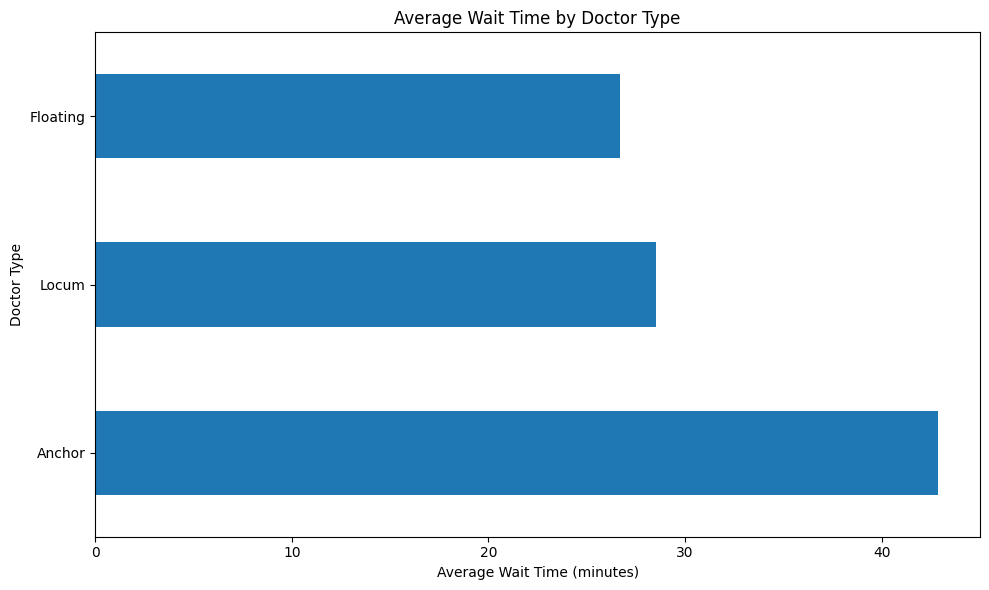

In [16]:
fig = go.Figure()
fig.add_trace(go.Bar(x=insights['revenue_by_day'].index, y=insights['revenue_by_day'].values,
                    text=insights['revenue_by_day'].values.round(2),
                    textposition='auto'))
fig.update_layout(title='Revenue by Day of Week',
                  xaxis_title='Day of Week',
                  yaxis_title='Average Revenue')
fig.show()

fig = px.bar(x=insights['busiest_hours'].index, y=insights['busiest_hours'].values,
            title='Busiest Hours',
            labels={'x': 'Hour of Day', 'y': 'Number of Visits'})
fig.show()

fig, ax = plt.subplots(figsize=(10, 6))
insights['avg_wait_time_by_doctor'].plot(kind='barh', ax=ax)
ax.set_title('Average Wait Time by Doctor Type')
ax.set_xlabel('Average Wait Time (minutes)')
ax.set_ylabel('Doctor Type')
plt.tight_layout()
plt.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=insights['efficiency_by_doctor'].index, y=insights['efficiency_by_doctor'].values,
                    text=insights['efficiency_by_doctor'].values.round(2),
                    textposition='auto'))
fig.update_layout(title='Revenue Efficiency by Doctor Type',
                  xaxis_title='Doctor Type',
                  yaxis_title='Revenue per Minute')
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=insights['revenue_by_day'].index, 
                         y=insights['revenue_by_day'].values,
                         mode='lines+markers', 
                         name='Revenue',
                         text=insights['revenue_by_day'].values.round(2),
                         textposition='top center'))

fig.update_layout(title='Revenue by Day of Week',
                  xaxis_title='Day of Week',
                  yaxis_title='Average Revenue')
fig.show()

heatmap_data = np.array(insights['busiest_hours']).reshape(1, -1)

fig = px.imshow(heatmap_data, 
                labels=dict(x="Hour of Day", y="Visits"),
                title="Busiest Hours Heatmap",
                color_continuous_scale='Viridis')
fig.show()

fig = go.Figure()
fig.add_trace(go.Pie(labels=insights['avg_wait_time_by_doctor'].index,
                     values=insights['avg_wait_time_by_doctor'].values,
                     textinfo='label+percent'))

fig.update_layout(title='Average Wait Time by Doctor Type')
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=insights['efficiency_by_doctor'].values, 
                     y=insights['efficiency_by_doctor'].index,
                     orientation='h',
                     text=insights['efficiency_by_doctor'].values.round(2),
                     textposition='auto'))

fig.update_layout(title='Revenue Efficiency by Doctor Type',
                  xaxis_title='Revenue per Minute',
                  yaxis_title='Doctor Type')
fig.show()